Reformer: The Efficient Transformer

https://arxiv.org/abs/2001.04451

https://data-analytics.fun/2020/06/17/understanding-reformer/

https://github.com/cerebroai/reformers/

### LOCALITY-SENSITIVE HASHING ATTENTION
#### Dot-product attention
Transforme で使用される標準的なattentionは、スケーリングされたドット積のattentionです(Vaswani et al., 2017)。入力は次元$d_k$のqueryとkey、および次元$d_v$のvalueで構成されます。すべてのkeyを使用したqueryの内積が計算され、$\sqrt{d_k}$でスケーリングされ、softmax関数が適用されてvalueの重みが取得されます。実際には、一連のqueryに対するattentionは同時に計算され、行列$Q$にまとめられます。keyとvalueも行列$K$と$V$にまとめられていると仮定すると、出力の行列は次のように定義されます。

$$
Attention(Q,K,V)=softmax\big(\frac{QK^T}{\sqrt{d_k}} \big)V
$$

#### Multi-head attention
Transformerでは、$d_{model}$次元のkey、value、およびqueryを使用して単一のattentionを計算する代わりに、query、key、およびvalueを、それぞれ $d_k$、$d_k$、および$d_v$次元へ$h$回線形射影します。 射影されたquery、key、およびvalueそれぞれにattentionが並行して適用され、$d_v$次元の出力値が生成されます。これらは連結され、再び射影されて最終的な値になります。このメカニズムは、Multi-head attentionとして知られています。

上記のMulti-head attentionは、query、key、およびvalueで動作しますが、通常、$[batch_size,length,d_{model}]$の形の$A$のみが与えられます。$A$から $Q$、$K$、および$V$を構築するために、Transformerは$3$つの異なる線形レイヤーを使用して、異なるパラメーターで$A$を$Q$、$K$、および$V$に射影します。 LSH  attentionの場合、queryとkey($Q$と$K$)を同一にする必要があります。 これは、同じ線形レイヤーを使用して$A$を$Q$および$K$に射影し、$V$には別のレイヤーを使用することで実現できます。このように動作するモデルをshared-QK Transformerと呼びます。 セクション$5$の実験で示したように、key$K$の長さをさらに正規化しても、QKの共有はTransformerのパフォーマンスに影響しないことがわかりました。

#### Hashing attention
LSH attentionのために、形状$[batch_size,length,d_{model}]$の$2$つのテンソル$Q=K$と$V$を考えます。 Multi-headのメカニズムはそのままにして、式$1$からのattentionの計算に注目します。 ただし、実際には$softmax(QK^T)$のみに関心があることに注意してください。$softmax$は最大の要素によって支配されるため、各クエリ$q_i$について、$q_i$に最も近い$K$内のkeyに注目するだけで済みます。 たとえば、$K$の長さが$64K$の場合、各$q_i$について、たとえば $32$個または$64$個の最も近いkeyの小さなサブセットのみを考慮することができます。これは効率的ですが、どのようにしてkeyの中から最近傍を見つけるかが問題となります。

#### Locality sensitive hashing(LSH)

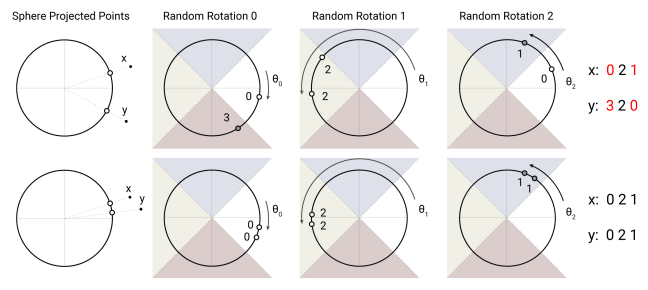

高次元空間で最近傍をすばやく見つける問題は、locality-sensitive hashing(LSH) によって解決できます。 各ベクトル$x$をハッシュ$h(x)$に割り当てるハッシュ方式は、近くのベクトルが高い確率で同じハッシュを取得し、遠くのベクトルで同じベクトルを取得しない場合、locality-sensitiveであると呼ばれます。 実際に今回は、近いベクトルが高い確率で同じハッシュを取得し、ハッシュバケットが高い確率で同様のサイズであることのみが必要です。これは、図のようにランダムな射影を使用することで実現されます(図$1$を参照)。$b$個のハッシュを取得するには、まずサイズ$[d_k, b/2]$のランダム行列$R$を固定します。次に、$h(x) = \arg \max([xR;−xR])$を定義します。ここで、$[u;v]$は$2$つのベクトルの連結を示します。 この方法は既知のLSHスキーム(Andoni et al.,2015) であり、簡単に実装してベクターのバッチに適用できます。

#### LSH attention
LSH Attentionを定式化します。最初に、$1$つのクエリ位置$i$について、通常のattentionの方程式を書き直します。

$$
o_i=\sum_{j\in\tilde{P}_i}\exp(q_i・k_j-z(i,P_i))v_j,\hspace{5mm}where\ P_i=\{j:i\geq j\}
$$

$P_i$は位置$i$のqueryが関係するセットを表し、$z$は分割関数(つまり、softmaxの正規化項)を表します。 わかりやすくするために、$\sqrt{d_k}$によるスケーリングを省略します。
バッチ処理のために、通常、より大きなセット$\tilde{P}_i = \{0,1,\cdots,l\} \supseteq P_i$に含まれていない要素をマスクする:

$$
o_i=\sum_{j\in\tilde{P}_i}\exp(q_i・k_j-m(j,P_i)-z(i,P_i))v_j,\hspace{5mm}where\ m(j,P_i)= \left\{
\begin{array}{ll}
\infty & if\ j\notin P_i\\
0 & otherwise
\end{array}
\right.
$$


ここで、LSH attentionに目を向けると、単一のハッシュバケット内でのみattentionを許可することによって、注意を向けることができるqueryの位置のセット$P_i$を制限するということを考えることができます。

$$
P_i=\{j:h(q_i)=h(k_j) \}
$$

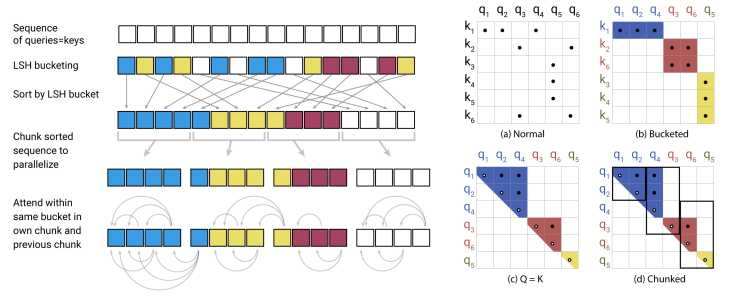

図2(a-b) は、full-attentionとハッシュ化された変数の概略的な比較を示しています。 (a)は、full-attentionのattention行列が一般的に疎であることを示していますが、計算ではこの疎性を利用していません。(b)では、queryとkeyはハッシュバケットに従って並べ替えられています。類似したアイテムは高い確率で同じバケットに分類されるため、各バケット内でのみattentionを許可することで、full-attentionを概算できます。

この定式化のハッシュバケットは、サイズが不均一になる傾向があるため、バケット間でのバッチ処理が困難になります。さらに、バケット内のqueryの数とkeyの数が等しくない場合があります。実際、バケットに多くのqueryが含まれていてもkeyが含まれていない可能性があります。これらの問題を軽減するために、まず$k_j=\frac{qj}{|q_j|}$を設定して $h(k_j) = h(q_j)$を保証します。次に、queryをバケット番号で並べ替え、各バケット内で系列位置で並べ替えます。これは、ソート後に$i → s_i$となる順列を定義します。並べ替えられたattention行列では、同じバケットのペアが対角線の近くに集まります(図2cを参照)。1つ前のチャンクや$m$個の連続するqueryのチャンク(並べ替え後)が互いに注意するというバッチアプローチに従うことができます(図2d)。これまでの表記に従うと、これは次の設定に対応します。

$$
\tilde{P}_i=\big\{j: \big\lfloor\frac{s_i}{m} \big\rfloor-1\leq \big\lfloor\frac{s_j}{m} \big\rfloor \leq \big\lfloor\frac{s_i}{m} \big\rfloor \big\}
$$

$\max_i|P_i|< m$の場合、$P_i \subseteq \tilde{P}_i$です。 実際には、$m = \frac{2l}{n_{buckets}}$($l$は系列の長さ)に設定します。バケットの平均サイズは$\frac{l}{n_{buckets}}$であり、バケットがそのサイズの$2$倍になる確率は十分に低いと仮定します。LSH attentionの全体的なプロセスは、図2にまとめられています。

#### Causal masking for shared-QK attention
Transformer decoderでは、マスキング($m(j,P_i)$)を使用して、将来に注意するのを防ぎます。 LSH attentionでマスキングを実装するには、すべてのquery/key ベクトルを位置インデックスに関連付け、query/keyベクトルの並べ替えに使用したのと同じ順列を使用して位置インデックスを並べ替え、比較操作を使用してマスクを計算します。

将来への注意は許可されていませんが、Transformerの典型的な実装では、各ポジションがそれ自体に注意を向けることができます。 このような動作は、shared-QK の定式化では望ましくありません。queryベクトルとそれ自体の内積は、ほとんどの場合、別の位置にあるベクトルとのqueryベクトルの内積よりも大きくなるためです。そのため、トークンに他の有効なattentionターゲットがない場合(系列の最初のトークンなど)を除いて、トークンがそれ自体に注意できないようにマスキングを変更します。
$$
N_{i,j}=\big|\big\{r':j\in P_i^{(r')}\big\} \big|\ and\ 
m_{i,j}^{(r)}=\left\{
\begin{array}{ll}
\infty & if\ j\notin P_i\\
10^5 & if\ i=j\\
\log N_{i,j} & otherwise
\end{array}
\right.
$$

### REVERSIBLE TRANSFORMER
#### RevNets
Reversible residualネットワークは、画像分類においてResNetsを置き換えることができることが示されました。 主なアイデアは、モデル パラメーターのみを使用して、任意のレイヤーのアクティベーションを次のレイヤーのアクティベーションから復元できるようにすることです。 通常のresidual layerが単一の入力から単一の出力を生成する関数$x → y$を実行し、$y = x + F(x)$という形式を持つのに対し、reversible residual layerは入力/出力のペア$(x_1, x_2) → (y_1, y_2)$で機能し、以下の方程式に従います。
$$
y_1=x_1+F(x_2)\\
y_2=x_2+G(y_1)
$$

残差を減算することで反転できます。

$$
x_2=y_2-G(y_1)\\
x_1=y_1-F(x_2)
$$

#### Reversible Transformer
revnetブロック内のattentionレイヤとfeed-forwardレイヤを組み合わせることで、RevNetをTransformerに適用します。上記の表記では、$F$がattentionレイヤになり、$G$がfeed-forwardレイヤになります。 Layer Normalizationは残差ブロック内に移動されることに注意してください。また、$X_1,X_2$は$X$をチャネル方向に分割したものとなります。

$$
Y_1=X_1+Attention(X_2)\\
Y_2=X_2+FeedFoward(Y_1)\\
$$

reversible Transformerは通常のTransformerと同じように実行されます。これを$x_1$と$x_2$の両方にサイズ$d_{model}$を持たせることでこれを実現できます。

#### Chunking
feed-forwardレイヤでの計算は、系列内の位置全体で完全に独立しているため、計算を$c$個のチャンクに分割できます。

$$
Y_2=[Y_2^{(1)},\cdots,Y_2^{(c)}]=[X_2^{(1)}+FeedFoward(Y_1^{(1)}),\cdots,X_2^{(c)}+FeedFoward(Y_1^{(c)})]
$$

In [822]:
import numpy as np
import tensorflow as tf

batch_size = 1
head_num = 1
length = 16
dk = 8
n_buckets = 4
m = length // n_buckets

QK = np.random.normal(size=(batch_size,head_num,length,dk))
V = np.random.normal(size=(batch_size,head_num,length,dk))

# ランダム行列 [hidden_dim, n_buckets//2]
R = np.random.normal(size=(dk, n_buckets//2))

# ハッシュ化された変数の計算
# [QK@R, -QK@R]: [batch_size, head_num, q_length, hidden_dim//head_num]@[hidden_dim/head_num, n_buckets] = [batch_size, head_num, q_length, n_buckets]
# np.argmax() : [batch_size, head_num, q_length]
hash_idx = np.argmax(np.concatenate([QK@R, -QK@R], axis=3), axis=3)
# 並べ替え用のインデックス
hash_sort = np.argsort(hash_idx, axis=2)
hash_sort_inv = np.argsort(hash_sort)
# ハッシュバケットの番号 [batch_size, head_num, q_length]
bucket_idx = hash_sort//m

# マスクの作成
# 同じハッシュ値の部分 [batch_size, head_num, n_buckets, q_length, q_length]
eq_hash1 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)
print(np.sort(hash_idx))
# 対角成分 [batch_size, head_num, n_buckets, q_length, q_length]
i_qe_j = np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, m, 1)
# 上三角成分 [batch_size, head_num, n_buckets, q_length, q_length]
tri_upper = np.triu(np.ones((batch_size, head_num,n_buckets, m, m)))==1
# 同じハッシュ値の部分で上三角成分のみ使用 [batch_size, head_num, n_buckets, q_length, q_length]
# 値はlog(n)を入れる
target = (eq_hash1*tri_upper)
targetn = target*np.log(m)
targetn[:,:,1:,:,:] = np.log(2*m)*targetn[:,:,1:,:,:]

# 1つ前のバケットも対象とする [batch_size, head_num, n_buckets-1, q_length, q_length]
# 最初のバケットは1ブロックのみ
eq_hash2 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m)[:,:,1:,:,:] == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)[:,:,:-1,:,:]

# 同じバケットに対するマスク
mask1 = targetn + i_qe_j*(10**5) + (1-target)*(10**9)
# ひとつ前のバケットに対するマスク
mask2 = eq_hash2*np.log(2*m) + (1-eq_hash2)*(10**9)
mask = np.concatenate([np.pad(mask2,  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=10**9), mask1], axis=3)

# queryとkey、valueをバケットに分ける
# [batch_size, head_num, q_length, hidden_dim//head_num]→[batch_size, head_num, n_buckets, q_length//n_buckets, hidden_dim//head_num]
QK_chank = np.take_along_axis(QK, hash_sort.reshape(batch_size,head_num,length,1), axis=2).reshape(batch_size, head_num,n_buckets, m, dk)
V_chank = np.take_along_axis(V, hash_sort.reshape(batch_size,head_num,length,1), axis=2).reshape(batch_size, head_num,n_buckets, m, dk)


# 後の処理のためにn_bucketsの先頭に0をpadding [batch_size, head_num, n_buckets+1, q_length//n_buckets, hidden_dim//head_num]
V_chank = np.pad(V_chank,  [(0,0),(0,0),(1,0),(0,0),(0,0)])
# 2バケットずつ並べる [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
V_chank=np.array([V_chank[:,:,i:i+2,:,:].reshape(batch_size, head_num,m*2,dk) for i in range(n_buckets)]).transpose(1,2,0,3,4)

# query×key
K = QK_chank
K = K/np.sqrt(np.sum(K**2, axis=4, keepdims=4))
K = np.concatenate([np.pad(K[:,:,:-1,:,:],  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=0),K], axis=3)
ba =  K@QK_chank.transpose(0,1,2,4,3) - mask
score_chank = tf.nn.softmax(ba, axis=3).numpy()#.transpose(0,1,2,4,3)

# valueをかけてattentionの出力を計算
# [batch_size, head_num, n_buckets, q_length//n_buckets, 2*q_length//n_buckets]@[batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
#       = [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
attn_weight_chank = score_chank.transpose(0,1,2,4,3)@V_chank

# attention scoreをもとの並び順に戻す
# [batch_size, head_num, q_length, q_length]
attn_score = np.zeros((batch_size,head_num, length, length))
attn_score[:,:,:m, :m] = score_chank[:,:,0,m:,:]
for i in range(0,n_buckets-1):
    attn_score[:,:,m*(i):m*(i+2), (i+1)*m:(i+2)*m] = score_chank[:,:,i,:,:]
attn_score = np.take_along_axis(attn_score, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
attn_score = np.take_along_axis(attn_score, hash_sort_inv.reshape(batch_size,head_num,1,length), axis=3)

# attentionの出力をもとの並び順に戻す
#attn_weight_chank = np.sort(np.concatenate([np.array(hash_sort).reshape(batch_size,head_num,length,1), attn_weight_chank.reshape(batch_size,head_num,length,dk)], axis=3), axis=2)[:,:,:,1:]
attn_weight_chank = attn_weight_chank.reshape(batch_size,head_num,length,dk)[0,0,hash_sort_inv]

[[[0 0 0 0 1 1 1 1 2 2 2 2 2 3 3 3]]]


In [203]:
# マスクの作成
# 同じハッシュ値の部分 [batch_size, head_num, n_buckets, q_length, q_length]
eq_hash1 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)
print(np.sort(hash_idx))
# 対角成分 [batch_size, head_num, n_buckets, q_length, q_length]
i_qe_j = np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, m, 1)
# 上三角成分 [batch_size, head_num, n_buckets, q_length, q_length]
tri_upper = np.triu(np.ones((batch_size, head_num,n_buckets, m, m)))==1
# 同じハッシュ値の部分で上三角成分のみ使用 [batch_size, head_num, n_buckets, q_length, q_length]
# 値はlog(n)を入れる
target = (eq_hash1*tri_upper)
targetn = target*np.log(m)
targetn[:,:,1:,:,:] = np.log(2*m)*targetn[:,:,1:,:,:]

# 1つ前のバケットも対象とする [batch_size, head_num, n_buckets-1, q_length, q_length]
# 最初のバケットは1ブロックのみ
eq_hash2 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m)[:,:,1:,:,:] == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)[:,:,:-1,:,:]

# 同じバケットに対するマスク
mask1 = targetn + i_qe_j*(10**5) + (1-target)*(10**9)
# ひとつ前のバケットに対するマスク
mask2 = eq_hash2*np.log(2*m) + (1-eq_hash2)*(10**9)
mask = np.concatenate([np.pad(mask2,  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=10**9), mask1], axis=3)



def make_lsh_mask(hash_idx, hash_sort, batch_size, head_num,n_buckets, m):
    # マスクの作成
    # 同じハッシュ値の部分 [batch_size, head_num, n_buckets, q_length, q_length]
    eq_hash1 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)
    # 対角成分 [batch_size, head_num, n_buckets, q_length, q_length]
    i_qe_j = np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, m, 1)
    # 上三角成分 [batch_size, head_num, n_buckets, q_length, q_length]
    tri_upper = np.triu(np.ones((batch_size, head_num,n_buckets, m, m)))==1
    # 同じハッシュ値の部分で上三角成分のみ使用 [batch_size, head_num, n_buckets, q_length, q_length]
    # 値はlog(n)を入れる
    target = (eq_hash1*tri_upper)
    targetn = target*np.log(m)
    targetn[:,:,1:,:,:] = np.log(2*m)*targetn[:,:,1:,:,:]

    # 1つ前のバケットも対象とする [batch_size, head_num, n_buckets-1, q_length, q_length]
    # 最初のバケットは1ブロックのみ
    eq_hash2 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m)[:,:,1:,:,:] == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)[:,:,:-1,:,:]

    # 同じバケットに対するマスク
    mask1 = targetn + i_qe_j*(10**5) + (1-target)*(10**9)
    # ひとつ前のバケットに対するマスク
    mask2 = eq_hash2*np.log(2*m) + (1-eq_hash2)*(10**9)
    mask = np.concatenate([np.pad(mask2,  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=10**9), mask1], axis=3)
    return mask

[[[0 0 0 0 0 1 1 1 1 1 1 2 3 3 3 3]]]


In [230]:
batch_size = 1
head_num = 1
length = 16
dk = 8
n_buckets = 4

m = length // n_buckets
rg = tf.random.Generator.from_seed(1)

QK = rg.normal(shape=[batch_size,head_num,length,dk], dtype=tf.float32)
V = rg.normal(shape=[batch_size,head_num,length,dk], dtype=tf.float32)

# ランダム行列 [hidden_dim, n_buckets//2]
R = np.random.normal(size=(dk, n_buckets//2))

# ハッシュ化された変数の計算
# [QK@R, -QK@R]: [batch_size, head_num, q_length, hidden_dim//head_num]@[hidden_dim/head_num, n_buckets] = [batch_size, head_num, q_length, n_buckets]
# np.argmax() : [batch_size, head_num, q_length]
hash_idx = np.argmax(np.concatenate([QK@R, -QK@R], axis=3), axis=3)
# 並べ替え用のインデックス
hash_sort = np.argsort(hash_idx, axis=2).astype(np.int32)
hash_sort_inv = np.argsort(hash_sort).astype(np.int32)

# マスクの作成
mask = make_lsh_mask(hash_idx, hash_sort, batch_size, head_num,n_buckets, m)

# queryとkey、valueをバケットに分ける
# [batch_size, head_num, q_length, hidden_dim//head_num]→[batch_size, head_num, n_buckets, q_length//n_buckets, hidden_dim//head_num]
QK_chank = tf.reshape(tf.experimental.numpy.take_along_axis(QK, hash_sort.reshape(batch_size,head_num,length,1), axis=2), [batch_size, head_num,n_buckets, m, dk])
V_chank = tf.reshape(tf.experimental.numpy.take_along_axis(V, hash_sort.reshape(batch_size,head_num,length,1), axis=2), [batch_size, head_num,n_buckets, m, dk])

# 後の処理のためにn_bucketsの先頭に0をpadding [batch_size, head_num, n_buckets+1, q_length//n_buckets, hidden_dim//head_num]
V_chank = tf.pad(V_chank,  [(0,0),(0,0),(1,0),(0,0),(0,0)], 'CONSTANT')
# 2バケットずつ並べる [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
V_chank=tf.concat([tf.reshape(V_chank[:,:,i:i+2,:,:], [batch_size, head_num,1,m*2,dk]) for i in range(n_buckets)], axis=2)

# query×key
K = QK_chank
K = K/tf.sqrt(tf.math.reduce_sum(K**2, axis=4, keepdims=4))
K = tf.concat([tf.pad(K[:,:,:-1,:,:],  [(0,0),(0,0),(1,0),(0,0),(0,0)], 'CONSTANT'),K], axis=3)
ba =  tf.matmul(K, QK_chank, transpose_b=True) - mask
score_chank = tf.nn.softmax(ba, axis=3)
score_chank = score_chank / np.sqrt(dk)

# valueをかけてattentionの出力を計算
# [batch_size, head_num, n_buckets, q_length//n_buckets, 2*q_length//n_buckets]@[batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
#       = [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
attn_weight_chank = tf.matmul(score_chank, V_chank, transpose_a=True)

# attention scoreをもとの並び順に戻す
# [batch_size, head_num, q_length, q_length]
atten_weight=tf.concat([
    tf.pad(score_chank[:,:,0,m:,:], [(0,0),(0,0),(0,m*(n_buckets-1)),(0,0)]),
    tf.concat([tf.pad(score_chank[:,:,i,:,:], [(0,0),(0,0),(m*(i),m*(n_buckets-2-i)),(0,0)]) for i in range(n_buckets-1)], axis=3)
],axis=3)

atten_weight = tf.experimental.numpy.take_along_axis(atten_weight, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
atten_weight = tf.experimental.numpy.take_along_axis(atten_weight, hash_sort_inv.reshape(batch_size,head_num,1,length), axis=3)
atten_weight = tf.cast(atten_weight, dtype=tf.float32)

context = tf.reshape(attn_weight_chank, [batch_size,head_num,length,dk])
context = tf.experimental.numpy.take_along_axis(context, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
context = tf.cast(context, dtype=tf.float32)

In [226]:
hash_sort

array([[[ 1,  3,  6,  7, 10, 12, 13, 15,  5,  8,  0,  2,  4,  9, 11, 14]]],
      dtype=int64)

In [32]:
V_chank[:,:,1:1+2,:,:]

<tf.Tensor: shape=(1, 1, 2, 4, 8), dtype=float32, numpy=
array([[[[[ 1.3023861e-01,  7.1243781e-01, -1.2218609e+00,
           -3.5243499e-01, -8.9998889e-01, -7.7583611e-01,
            7.4146372e-01, -7.0768762e-01],
          [ 3.4655526e-01, -1.2194412e-02, -8.2423073e-01,
            3.3463132e-02,  2.0959428e-01,  1.8160588e+00,
            2.8758731e-01, -5.5129969e-01],
          [-6.5089881e-01, -9.5691371e-01, -1.3597654e+00,
           -6.6981852e-02,  6.1688787e-01,  2.7421087e-01,
            1.7481041e+00, -2.8000327e-02],
          [ 1.2012217e+00,  7.6496303e-01, -1.9928725e-01,
           -6.3204467e-01, -2.0329487e-01,  1.6626168e+00,
            7.4678725e-01, -1.3241549e+00]],

         [[ 1.3242230e-01,  4.1362736e-01,  8.2733609e-02,
            9.7662702e-02,  9.6115208e-01,  6.3303983e-01,
            3.7903225e-01, -1.9490684e+00],
          [ 2.5111401e+00, -7.0886356e-01,  2.3329012e-01,
           -1.0424997e+00,  5.5341646e-02, -8.9422882e-01,
           -8

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Activation, Dropout, LayerNormalization, Reshape, Embedding, MultiHeadAttention
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt

In [6]:
def make_lsh_mask(hash_idx, hash_sort, batch_size, head_num,n_buckets, m):
    # マスクの作成
    # 同じハッシュ値の部分 [batch_size, head_num, n_buckets, q_length, q_length]
    eq_hash1 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)
    # 対角成分 [batch_size, head_num, n_buckets, q_length, q_length]
    i_qe_j = np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, m, 1)
    # 上三角成分 [batch_size, head_num, n_buckets, q_length, q_length]
    tri_upper = np.triu(np.ones((batch_size, head_num,n_buckets, m, m)))==1
    # 同じハッシュ値の部分で上三角成分のみ使用 [batch_size, head_num, n_buckets, q_length, q_length]
    # 値はlog(n)を入れる
    target = (eq_hash1*tri_upper)
    targetn = target*np.log(m)
    targetn[:,:,1:,:,:] = np.log(2*m)*targetn[:,:,1:,:,:]

    # 1つ前のバケットも対象とする [batch_size, head_num, n_buckets-1, q_length, q_length]
    # 最初のバケットは1ブロックのみ
    eq_hash2 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m)[:,:,1:,:,:] == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)[:,:,:-1,:,:]

    # 同じバケットに対するマスク
    mask1 = targetn + i_qe_j*(10**5) + (1-target)*(10**9)
    # ひとつ前のバケットに対するマスク
    mask2 = eq_hash2*np.log(2*m) + (1-eq_hash2)*(10**9)
    mask = np.concatenate([np.pad(mask2,  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=10**9), mask1], axis=3)
    return mask

In [7]:
class AddPositionalEncoding(Layer):
    '''
    入力テンソルに対し、位置の情報を付与して返すレイヤー
    see: https://arxiv.org/pdf/1706.03762.pdf

    PE_{pos, 2i}   = sin(pos / 10000^{2i / d_model})
    PE_{pos, 2i+1} = cos(pos / 10000^{2i / d_model})
    '''
    def call(self, inputs):
        fl_type = inputs.dtype
        batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

        depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
        depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
        depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

        # cos(x) == sin(x + π/2)
        phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
        phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

        pos_counter = tf.range(max_length)
        pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

        positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
        # [batch_size, max_length, depth]
        positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

        return inputs + positional_encoding

In [37]:
class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, attn_mode='full', n_buckets=None, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super(MultiHeadAttention, self).__init__()
        self.attn_mode = attn_mode
        self.n_buckets = n_buckets
        
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = query.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数(q_length)
        hidden_dim = shape[1]*shape[3] # 特徴ベクトルの長さ(head_num × hidden_dim//head_num = hidden_dim)
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [1, 1, (q|m)_length, (q|m)_length] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight
    
    def LSHatten(self, QK, V, n_buckets, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = QK.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num   
        batch_size = shape[0]
        head_num = shape[1]
        length = shape[2]
        dk = shape[3]
        n_buckets = n_buckets
        m = length // n_buckets

        # ランダム行列 [hidden_dim, n_buckets//2]
        R = np.random.normal(size=(dk, n_buckets//2))

        # ハッシュ化された変数の計算
        # [QK@R, -QK@R]: [batch_size, head_num, q_length, hidden_dim//head_num]@[hidden_dim/head_num, n_buckets] = [batch_size, head_num, q_length, n_buckets]
        # np.argmax() : [batch_size, head_num, q_length]
        hash_idx = np.argmax(np.concatenate([QK@R, -QK@R], axis=3), axis=3)
        # 並べ替え用のインデックス
        hash_sort = np.argsort(hash_idx, axis=2).astype(np.int32)
        hash_sort_inv = np.argsort(hash_sort).astype(np.int32)

        # マスクの作成
        mask = make_lsh_mask(hash_idx, hash_sort, batch_size, head_num,n_buckets, m)

        # queryとkey、valueをバケットに分ける
        # [batch_size, head_num, q_length, hidden_dim//head_num]→[batch_size, head_num, n_buckets, q_length//n_buckets, hidden_dim//head_num]
        QK_chank = tf.reshape(tf.experimental.numpy.take_along_axis(QK, hash_sort.reshape(batch_size,head_num,length,1), axis=2), [batch_size, head_num,n_buckets, m, dk])
        V_chank = tf.reshape(tf.experimental.numpy.take_along_axis(V, hash_sort.reshape(batch_size,head_num,length,1), axis=2), [batch_size, head_num,n_buckets, m, dk])

        # 後の処理のためにn_bucketsの先頭に0をpadding [batch_size, head_num, n_buckets+1, q_length//n_buckets, hidden_dim//head_num]
        V_chank = tf.pad(V_chank,  [(0,0),(0,0),(1,0),(0,0),(0,0)], 'CONSTANT')
        # 2バケットずつ並べる [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
        V_chank=tf.concat([tf.reshape(V_chank[:,:,i:i+2,:,:], [batch_size, head_num,1,m*2,dk]) for i in range(n_buckets)], axis=2)

        # query×key
        K = QK_chank
        K = K/tf.sqrt(tf.math.reduce_sum(K**2, axis=4, keepdims=4))
        K = tf.concat([tf.pad(K[:,:,:-1,:,:],  [(0,0),(0,0),(1,0),(0,0),(0,0)], 'CONSTANT'),K], axis=3)
        score_chank =  tf.matmul(K, QK_chank, transpose_b=True) - tf.cast(mask, dtype=tf.float32)
        score_chank = tf.nn.softmax(score_chank, axis=3)

        # valueをかけてattentionの出力を計算
        # [batch_size, head_num, n_buckets, q_length//n_buckets, 2*q_length//n_buckets]@[batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
        #       = [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
        attn_weight_chank = tf.matmul(score_chank, V_chank, transpose_a=True)

        # attention scoreをもとの並び順に戻す
        # [batch_size, head_num, q_length, q_length]
        atten_weight=tf.concat([
            tf.pad(score_chank[:,:,0,m:,:], [(0,0),(0,0),(0,m*(n_buckets-1)),(0,0)]),
            tf.concat([tf.pad(score_chank[:,:,i,:,:], [(0,0),(0,0),(m*(i),m*(n_buckets-2-i)),(0,0)]) for i in range(n_buckets-1)], axis=3)
        ],axis=3)

        atten_weight = tf.experimental.numpy.take_along_axis(atten_weight, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
        atten_weight = tf.experimental.numpy.take_along_axis(atten_weight, hash_sort_inv.reshape(batch_size,head_num,1,length), axis=3)

        context = tf.reshape(attn_weight_chank, [batch_size,head_num,length,dk])
        context = tf.experimental.numpy.take_along_axis(context, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, length, dk))
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim]
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        # score_weightsはEncoderではNoneとする
        if self.attn_mode == 'full':
            context, attn_weights = self.atten(query, key, value, attention_mask, training)
        elif self.attn_mode == 'lsh':
            context, attn_weights = self.LSHatten(query, value, self.n_buckets, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

In [38]:
class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

In [39]:
class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

In [40]:
class EncoderLayer(Layer):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, attn_mode='full', n_buckets=None, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim,
                                       heads_num = heads_num,
                                       attn_mode=attn_mode,
                                       n_buckets=n_buckets,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, input, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, input, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

In [41]:
class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate, attn_mode='full', n_buckets=None):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num, attn_mode,n_buckets) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, q_length, hidden_dim]
        memory: 入力 [batch_size, m_length, hidden_dim]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)

        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

In [42]:
class DecoderLayer(Layer):
    """
    3つのsub-layerを持つ
    decoder layer : before ->[mask attention -> enc attention -> FF]-> next
    mask attentionは未来の情報を参照しないためのマスクを適用
    enc attentionはencoderの出力をkey, valueとする。
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, hidden_dim, heads_num, attn_mode='full', n_buckets=None, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # mask self-attention : mask処理を行う
        self.mask_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, attn_mode=attn_mode, n_buckets=n_buckets, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # attention : encoderの出力をmemory(key,value)として受け取る
        self.enc_atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        if return_attention_scores:
            x, dec_attn_weights = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=return_attention_scores)
            x, encdec_attn_weights = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=return_attention_scores)
            x = self.ffn(x)
            return x, dec_attn_weights, encdec_attn_weights
        else:
            x = self.mask_atten(input, training, memory=input, attention_mask=attention_mask, return_attention_scores=False)
            x = self.enc_atten(x, training, memory=memory, attention_mask=None, return_attention_scores=False)
            x = self.ffn(x)
            return x

In [43]:
class Decoder(Layer):
    '''
    TransformerのDecoder
    '''
    def __init__(self, hopping_num, heads_num, hidden_dim,drop_rate, attn_mode='full', n_buckets=None):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [DecoderLayer(hidden_dim, heads_num, attn_mode,n_buckets) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.add_position_embedding(input)
        query = self.input_dropout_layer(embedded_input, training=training)
        
        # Decoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, dec_attn_weights, encdec_attn_weights = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), dec_attn_weights, encdec_attn_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, memory, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

In [45]:
class SparseTransformerTimeSeriesForecastModel(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(self, hopping_num, heads_num, hidden_dim, drop_rate, local_attn_ctx=2, attn_mode='full', n_buckets=None):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.local_attn_ctx = local_attn_ctx
        self.heads_num = heads_num
        
        self.encoder = Encoder(hopping_num, heads_num, hidden_dim, drop_rate, attn_mode, n_buckets)
        self.decoder = Decoder(hopping_num, heads_num, hidden_dim, drop_rate, attn_mode, n_buckets)
        
        # 全結合層
        self.fc = Dense(8)
        self.dropout = Dropout(drop_rate)
        self.final_layer = Dense(1)

    def call(self, inputs, training, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        enc_input, dec_input = inputs
        
        #local_mask = self._create_factorized_mask(dec_input, 'local', self.local_attn_ctx)
        #strided_mask = self._create_factorized_mask(dec_input, 'strided', self.local_attn_ctx)
        
        #self_attention_mask=self._create_look_ahead_mask(dec_input)
        #self_attention_mask=tf.concat([local_mask if m%2 else strided_mask for m in range(self.heads_num)], axis=1)
        
       # Encoderの出力はDecoderへの入力(memory)となる
        # enc_input : [batch_size, enc_length, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(enc_input, memory=enc_input, attention_mask=None,return_attention_scores=return_attention_scores)
        
        # dec_input : [batch_size, dec_length, hidden_dim]
        # dec_output : [batch_size, dec_length, hidden_dim]
        # dec_attn_weights : [batch_size, dec_length, dec_length]
        # encdec_attn_weights : [batch_size, dec_length, enc_length]
        if return_attention_scores:
            dec_output, dec_attn_weights, encdec_attn_weights = self.decoder(dec_input, memory=enc_output, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            dec_output = self.decoder(dec_input, memory=enc_output, attention_mask=None,return_attention_scores=return_attention_scores)
       
        
        # [batch_size, dec_length, hidden_dim] -> [batch_size, dec_length]
        dec_output = self.fc(dec_output)
        dec_output = self.dropout(dec_output)
        dec_output = self.final_layer(dec_output)

        if return_attention_scores:
            return dec_output, enc_atten_weights, dec_attn_weights, encdec_attn_weights
        else:
            return dec_output
    
    def _create_look_ahead_mask(self, x):
        batch_size, length, _ = x.shape
        autoregression_array = tf.logical_not(tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])
        return tf.cast(autoregression_array, dtype=tf.float32)
    
    def _create_factorized_mask(self, x_dec, attn_mode, local_attn_ctx=None):
        batch_size, n, _ = x_dec.shape
        if attn_mode == 'all':
            b = tf.linalg.band_part(tf.ones([n, n]), -1, 0)
        elif attn_mode == 'local':
            bandwidth = local_attn_ctx
            ctx = tf.minimum(n - 1, bandwidth - 1)
            b = tf.linalg.band_part(tf.ones([n, n]), ctx, 0)
        elif attn_mode == 'strided':
            stride = local_attn_ctx
            x = tf.reshape(tf.range(n, dtype=tf.int32), [n, 1])
            y = tf.transpose(x)
            z = tf.zeros([n, n], dtype=tf.int32)
            q = z + x
            k = z + y
            c1 = q >= k
            c2 = tf.equal(tf.math.floormod(q - k, stride), 0)
            c3 = tf.logical_and(c1, c2)
            b = tf.cast(c3, tf.float32)
        else:
            raise ValueError('Not yet implemented')
        b = tf.reshape(b, [1, 1, n, n])

        return 1-b

In [46]:
class minmaxscaling:
    def __init__(self,max_value, min_value, upl=0, downl=0):
        self.max = max_value + max_value*upl
        self.min = min_value - min_value*downl
    
    def translate(self, x):
        return (x - self.min) / (self.max - self.min)

def make_ts_data(window_width, dmodel, pred_points, split_point):
    data = pd.read_csv('ilidata.csv')
    data = np.array(data[['WEIGHTED_ILI']])

    scaler = minmaxscaling(8, 0, 0.1)
    data = scaler.translate(data).ravel()

    train_data = data[:split_point]
    test_data = data[split_point-dmodel:570]

    train_emb_data = np.array([train_data[i:i+dmodel] for i in range(len(train_data)-dmodel)])
    test_emb_data = np.array([test_data[i:i+dmodel] for i in range(len(test_data)-dmodel)])

    enc_train = np.array([train_emb_data[i:i+window_width] for i in range(len(train_emb_data)-window_width-pred_points)])
    dec_train = np.array([train_emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(train_emb_data)-window_width-pred_points)])
    y_train = np.array([train_emb_data[i+window_width:i+window_width+pred_points] for i in range(len(train_emb_data)-window_width-pred_points)])

    enc_test = np.array([test_emb_data[i:i+window_width] for i in range(len(test_emb_data)-window_width-pred_points)])
    dec_test = np.array([test_emb_data[i+window_width-1:i+window_width-1+pred_points] for i in range(len(test_emb_data)-window_width-pred_points)])
    y_test = np.array([test_emb_data[i+window_width:i+window_width+pred_points] for i in range(len(test_emb_data)-window_width-pred_points)])

    enc_train = tf.constant(enc_train)
    enc_test = tf.constant(enc_test)
    dec_train = tf.constant(dec_train)
    dec_test = tf.constant(dec_test)
    y_train = tf.constant(y_train)
    y_test = tf.constant(y_test)

    print('encinput_train ', enc_train.shape)
    print('decinput_train ', dec_train.shape)
    print('y_train ', y_train.shape)

    print('encinput_test ', enc_test.shape)
    print('decinput_test ', dec_test.shape)
    print('y_test ', y_test.shape)
    return enc_train, dec_train, y_train, enc_test, dec_test, y_test

window_width = 10 # 予測に使う点数
dmodel = 8 # embeddingの次元
pred_points = 4 # 予測する点数
split_point = 515 # trainとtestを分ける点
enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

#plt.plot(np.arange(split_point), train_data);
#plt.plot(np.arange(split_point-dmodel,570), test_data)
#plt.xlim(0,600);

encinput_train  (493, 10, 8)
decinput_train  (493, 4, 8)
y_train  (493, 4, 8)
encinput_test  (41, 10, 8)
decinput_test  (41, 4, 8)
y_test  (41, 4, 8)


In [47]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    lr = (dmodel**0.5) * min(epoch**0.5, epoch * (5000**(-1.5)))
    return lr


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

model = SparseTransformerTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=1, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            n_buckets=2,
            attn_mode='lsh',
            drop_rate=0.2)

criterion = tf.keras.losses.MeanSquaredError()
optimizer = optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-09, amsgrad=False)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'], run_eagerly=True)

In [48]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=1, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

62/62 - 44s - loss: 3.8635 - mse: 3.8635 - lr: 0.0000e+00 - 44s/epoch - 704ms/step
43.74873208999634


tf.Tensor(
[[[ 0.9006953   0.91408974 -0.40822813 ...  1.4700242  -0.08466014
   -0.5767314 ]
  [ 0.9006953   0.91408974 -0.40822813 ...  1.4700242  -0.08466014
   -0.5767314 ]
  [ 0.9098283   0.48812047 -0.5346367  ...  1.1937445   0.0903938
   -0.2897508 ]
  ...
  [ 0.98098654  0.5009325  -0.67974585 ...  1.1698395  -0.11248111
   -0.24331905]
  [ 1.0297318   0.14054167 -0.61651653 ...  0.9810169   0.00934525
    0.33310285]
  [ 1.0297318   0.14054167 -0.61651653 ...  0.9810169   0.00934525
    0.33310285]]

 [[ 0.9060829   0.9077572  -0.41902763 ...  1.4685321  -0.09700882
   -0.57529473]
  [ 0.9060829   0.9077572  -0.41902763 ...  1.4685321  -0.09700882
   -0.57529473]
  [ 0.9216596   0.49370798 -0.5418884  ...  1.1923285   0.08067989
   -0.284617  ]
  ...
  [ 0.99074477  0.51368743 -0.6804761  ...  1.1770852  -0.11654295
   -0.24532211]
  [ 1.0391406   0.15895484 -0.6065429  ...  0.99626815  0.01512192
    0.3321706 ]
  [ 1.0391406   0.15895484 -0.6065429  ...  0.99626815  0.01512

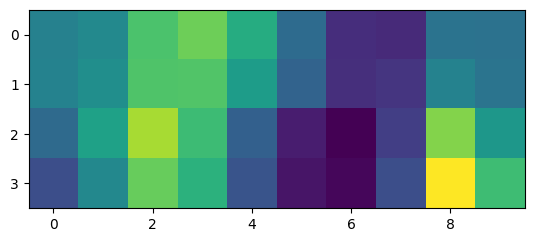

In [35]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [103]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

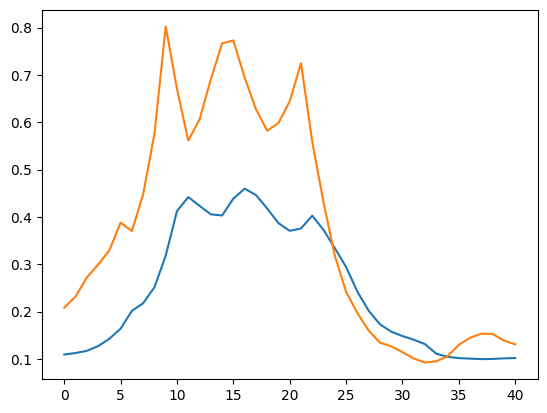

In [104]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,0,-1]);

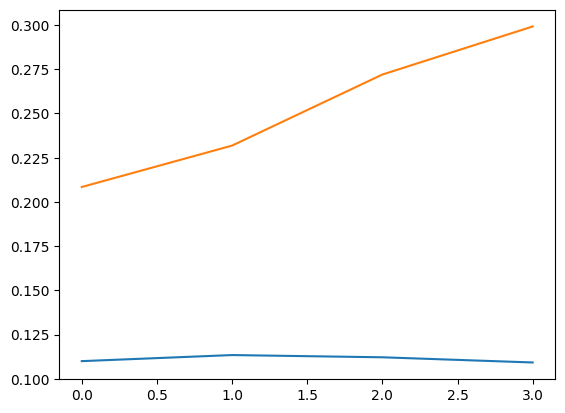

In [105]:
plt.plot(pred_results[0,0])
plt.plot(y_test[0,:,-1]);

In [106]:
window_width = 10
dmodel = 16
pred_points = 8

enc_train, dec_train, y_train, enc_test, dec_test, y_test = make_ts_data(window_width, dmodel, pred_points, split_point)

encinput_train  (481, 10, 16)
decinput_train  (481, 8, 16)
y_train  (481, 8, 16)
encinput_test  (37, 10, 16)
decinput_test  (37, 8, 16)
y_test  (37, 8, 16)


In [107]:
model = SparseTransformerTimeSeriesForecastModel(hopping_num=4, # Multi-head Attentionの繰り返し数
            heads_num=2, # Multi-head Attentionのヘッド数
            hidden_dim=dmodel, # Embeddingの次数
            drop_rate=0.2)

model.compile(loss=criterion, optimizer=optimizer, metrics=['mse'])

In [108]:
start = time.time()
history=model.fit([enc_train,dec_train], y_train, batch_size=8, epochs=200, callbacks=[lr_decay],verbose=2)
elapsed_time = time.time() - start
print(elapsed_time)

Epoch 1/200
61/61 - 13s - loss: 1.8863 - mse: 1.8863 - lr: 0.0000e+00 - 13s/epoch - 213ms/step
Epoch 2/200
61/61 - 1s - loss: 1.7571 - mse: 1.7571 - lr: 1.1314e-05 - 891ms/epoch - 15ms/step
Epoch 3/200
61/61 - 1s - loss: 1.6228 - mse: 1.6228 - lr: 2.2627e-05 - 906ms/epoch - 15ms/step
Epoch 4/200
61/61 - 1s - loss: 1.4768 - mse: 1.4768 - lr: 3.3941e-05 - 868ms/epoch - 14ms/step
Epoch 5/200
61/61 - 1s - loss: 1.3067 - mse: 1.3067 - lr: 4.5255e-05 - 840ms/epoch - 14ms/step
Epoch 6/200
61/61 - 1s - loss: 1.1279 - mse: 1.1279 - lr: 5.6569e-05 - 854ms/epoch - 14ms/step
Epoch 7/200
61/61 - 1s - loss: 0.9409 - mse: 0.9409 - lr: 6.7882e-05 - 837ms/epoch - 14ms/step
Epoch 8/200
61/61 - 1s - loss: 0.7545 - mse: 0.7545 - lr: 7.9196e-05 - 909ms/epoch - 15ms/step
Epoch 9/200
61/61 - 1s - loss: 0.6378 - mse: 0.6378 - lr: 9.0510e-05 - 830ms/epoch - 14ms/step
Epoch 10/200
61/61 - 1s - loss: 0.5132 - mse: 0.5132 - lr: 1.0182e-04 - 831ms/epoch - 14ms/step
Epoch 11/200
61/61 - 1s - loss: 0.4028 - mse: 0.4

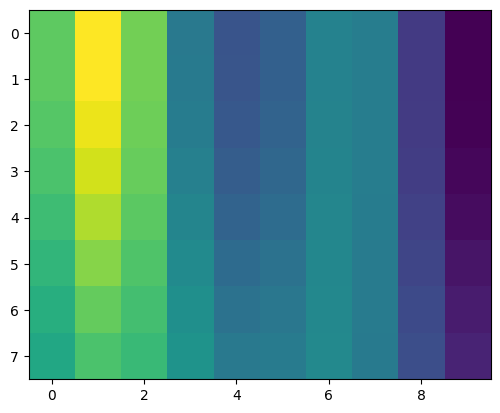

In [109]:
p, _, _, attn = model([enc_test,dec_test], return_attention_scores=True)
plt.imshow(attn[0,0])

In [110]:
pred_results = []

for j in range(len(enc_test)):
    for_pred = np.zeros((1,pred_points,dmodel))
    new_data = enc_test[j:j+1,-1:]

    for i in range(pred_points):
        for_pred[0,i,:] = new_data
        y_pred = model.predict([enc_test[j:j+1],for_pred], verbose=0)
        new_data = np.concatenate([enc_test[j:j+1,-1:,(i+1):], y_pred[0][:i+1].reshape(1,1,i+1)], axis=2)
    pred_results.append(y_pred)

pred_results = np.array(pred_results)

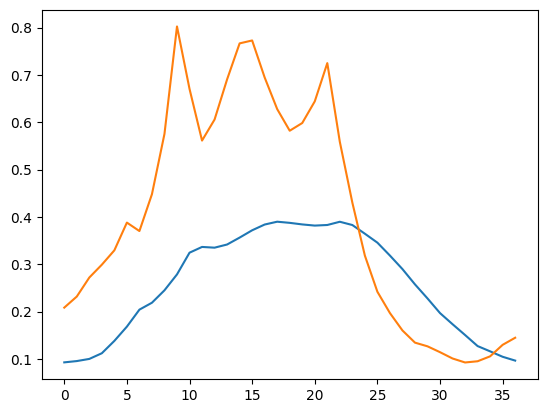

In [111]:
plt.plot(pred_results[:,0,-1,0])
plt.plot(y_test[:,0,-1]);

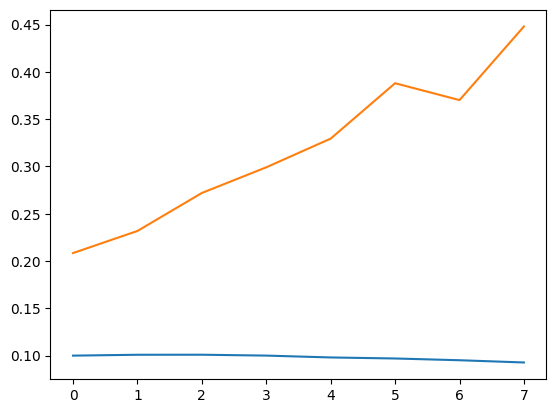

In [112]:
plt.plot(pred_results[0,0])
plt.plot(y_test[0,:,-1]);

In [837]:
batch_size = 8
length = 16
hidden_dim = 512

QK = np.random.normal(size=(batch_size,length,hidden_dim))

In [838]:
model = MultiHeadAttention(
        hidden_dim = 512,
        heads_num = 8,
        n_buckets=4,
        attn_mode='full',
        drop_rate = 0.5
    )

_,m1=model(QK, memory=QK, return_attention_scores=True)

In [839]:
model = MultiHeadAttention(
        hidden_dim = 512,
        heads_num = 8,
        n_buckets=4,
        attn_mode='lsh',
        drop_rate = 0.5
    )

_,m2=model(QK, memory=QK, return_attention_scores=True)

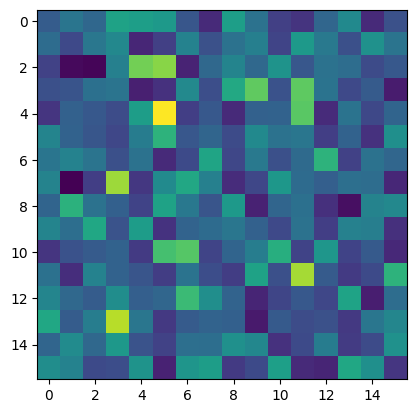

In [840]:
plt.imshow(m1[0,0])

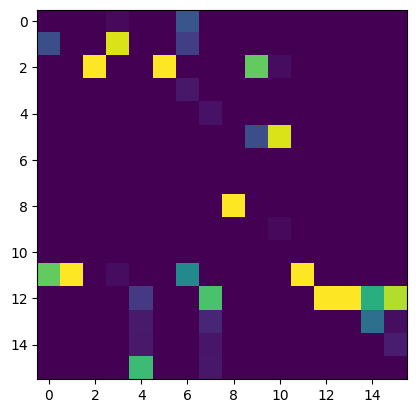

In [841]:
plt.imshow(m2[0,0])

In [578]:
import numpy as np
import tensorflow as tf

batch_size = 1
head_num = 1
length = 20
dk = 6
n_buckets = 4
m = length // n_buckets

QK = np.random.normal(size=(batch_size,head_num,length,dk))
V = np.random.normal(size=(batch_size,head_num,length,dk))

# ランダム行列 [hidden_dim, n_buckets//2]
R = np.random.normal(size=(dk, n_buckets//2))

In [579]:
# ハッシュ化された変数の計算
# [QK@R, -QK@R]: [batch_size, head_num, q_length, hidden_dim//head_num]@[hidden_dim/head_num, n_buckets] = [batch_size, head_num, q_length, n_buckets]
# np.argmax() : [batch_size, head_num, q_length]
hash_idx = np.argmax(np.concatenate([QK@R, -QK@R], axis=3), axis=3)
# 並べ替え用のインデックス
hash_sort = np.argsort(hash_idx, axis=2)
hash_sort_inv = np.argsort(hash_sort)
# ハッシュバケットの番号 [batch_size, head_num, q_length]
bucket_idx = hash_sort//m
print(hash_idx)
print(hash_sort)
print(hash_sort_inv)
print(bucket_idx)

[[[3 2 3 0 3 2 3 1 0 0 2 2 3 0 3 1 1 0 1 2]]]
[[[ 9 17  3 13  8 16 15  7 18 11 19  5  1 10  6 12 14  4  2  0]]]
[[[19 12 18  2 17 11 14  7  4  0 13  9 15  3 16  6  5  1  8 10]]]
[[[1 3 0 2 1 3 3 1 3 2 3 1 0 2 1 2 2 0 0 0]]]


In [654]:
# マスクの作成
# 同じハッシュ値の部分 [batch_size, head_num, n_buckets, q_length, q_length]
print(np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m))
eq_hash1 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)
eq_hash1[0,0]

[[[[[0 0 0 0 0]]

   [[1 1 1 1 2]]

   [[2 2 2 2 3]]

   [[3 3 3 3 3]]]]]


array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [False, False, False, False,  True]],

       [[ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [False, False, False, False,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]])

In [581]:
# 対角成分 [batch_size, head_num, n_buckets, q_length, q_length]
i_qe_j = np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, 1, m) == np.sort(hash_sort).reshape(batch_size, head_num,n_buckets, m, 1)
i_qe_j

array([[[[[ True, False, False, False, False],
          [False,  True, False, False, False],
          [False, False,  True, False, False],
          [False, False, False,  True, False],
          [False, False, False, False,  True]],

         [[ True, False, False, False, False],
          [False,  True, False, False, False],
          [False, False,  True, False, False],
          [False, False, False,  True, False],
          [False, False, False, False,  True]],

         [[ True, False, False, False, False],
          [False,  True, False, False, False],
          [False, False,  True, False, False],
          [False, False, False,  True, False],
          [False, False, False, False,  True]],

         [[ True, False, False, False, False],
          [False,  True, False, False, False],
          [False, False,  True, False, False],
          [False, False, False,  True, False],
          [False, False, False, False,  True]]]]])

In [582]:
# 上三角成分 [batch_size, head_num, n_buckets, q_length, q_length]
tri_upper = np.triu(np.ones((batch_size, head_num,n_buckets, m, m)))==1
tri_upper

array([[[[[ True,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False, False,  True,  True,  True],
          [False, False, False,  True,  True],
          [False, False, False, False,  True]],

         [[ True,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False, False,  True,  True,  True],
          [False, False, False,  True,  True],
          [False, False, False, False,  True]],

         [[ True,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False, False,  True,  True,  True],
          [False, False, False,  True,  True],
          [False, False, False, False,  True]],

         [[ True,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False, False,  True,  True,  True],
          [False, False, False,  True,  True],
          [False, False, False, False,  True]]]]])

In [583]:
# 同じハッシュ値の部分で上三角成分のみ使用 [batch_size, head_num, n_buckets, q_length, q_length]
# 値はlog(n)を入れる
target = (eq_hash1*tri_upper)
targetn = target*np.log(m)
targetn[:,:,1:,:,:] = np.log(2*m)*targetn[:,:,1:,:,:]
targetn

array([[[[[1.60943791, 1.60943791, 1.60943791, 1.60943791, 1.60943791],
          [0.        , 1.60943791, 1.60943791, 1.60943791, 1.60943791],
          [0.        , 0.        , 1.60943791, 1.60943791, 1.60943791],
          [0.        , 0.        , 0.        , 1.60943791, 1.60943791],
          [0.        , 0.        , 0.        , 0.        , 1.60943791]],

         [[3.70586775, 3.70586775, 3.70586775, 3.70586775, 0.        ],
          [0.        , 3.70586775, 3.70586775, 3.70586775, 0.        ],
          [0.        , 0.        , 3.70586775, 3.70586775, 0.        ],
          [0.        , 0.        , 0.        , 3.70586775, 0.        ],
          [0.        , 0.        , 0.        , 0.        , 3.70586775]],

         [[3.70586775, 3.70586775, 3.70586775, 3.70586775, 0.        ],
          [0.        , 3.70586775, 3.70586775, 3.70586775, 0.        ],
          [0.        , 0.        , 3.70586775, 3.70586775, 0.        ],
          [0.        , 0.        , 0.        , 3.70586775, 0

In [585]:
# 1つ前のバケットも対象とする [batch_size, head_num, n_buckets-1, q_length, q_length]
# 最初のバケットは1ブロックのみ
eq_hash2 = np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, 1, m)[:,:,1:,:,:] == np.sort(hash_idx).reshape(batch_size, head_num,n_buckets, m, 1)[:,:,:-1,:,:]
eq_hash2

array([[[[[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False]],

         [[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [ True,  True,  True,  True, False]],

         [[False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [False, False, False, False, False],
          [ True,  True,  True,  True,  True]]]]])

In [586]:
# 同じバケットに対するマスク
mask1 = targetn + i_qe_j*(10**5) + (1-target)*(10**9)
mask1

array([[[[[1.00001609e+05, 1.60943791e+00, 1.60943791e+00,
           1.60943791e+00, 1.60943791e+00],
          [1.00000000e+09, 1.00001609e+05, 1.60943791e+00,
           1.60943791e+00, 1.60943791e+00],
          [1.00000000e+09, 1.00000000e+09, 1.00001609e+05,
           1.60943791e+00, 1.60943791e+00],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00001609e+05, 1.60943791e+00],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00001609e+05]],

         [[1.00003706e+05, 3.70586775e+00, 3.70586775e+00,
           3.70586775e+00, 1.00000000e+09],
          [1.00000000e+09, 1.00003706e+05, 3.70586775e+00,
           3.70586775e+00, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00003706e+05,
           3.70586775e+00, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00003706e+05, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1

In [587]:
# ひとつ前のバケットに対するマスク
mask2 = eq_hash2*np.log(2*m) + (1-eq_hash2)*(10**9)
mask2

array([[[[[1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09]],

         [[1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [1.00000000e+09, 1.00000000e+09, 1.00000000e+09,
           1.00000000e+09, 1.00000000e+09],
          [2.30258509e+00, 2.30258509e+00, 2.30258509e+00,
           2

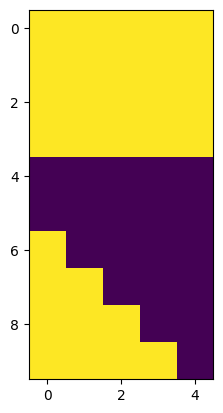

In [723]:
mask = np.concatenate([np.pad(mask2,  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=1e9), mask1], axis=3)
plt.imshow(mask[0,0,3])

In [589]:
QK

array([[[[-0.61835   , -1.10716533, -0.25393702, -0.43657147,
          -1.96163357, -1.62082157],
         [ 0.23707265,  1.54821816, -1.00922067,  0.94051002,
           1.65814672,  0.29131415],
         [ 2.12340713, -0.87572107, -0.63070298,  1.60612278,
          -0.85146427,  1.49680186],
         [ 0.14058647,  0.59697206, -0.33629694,  0.14294583,
          -0.65358914,  1.02505598],
         [-1.80935631, -0.11429375, -1.3078284 ,  1.50518649,
           1.35192389, -0.15208924],
         [-0.14583821,  2.81347362,  0.13602913, -0.10751793,
          -0.95368626, -0.07515005],
         [ 1.16689191, -2.3070322 , -0.43867447, -0.2085275 ,
          -1.599534  , -1.73433222],
         [-1.10854348, -0.56643801,  1.88367059, -0.06048952,
           1.31341367, -0.09543083],
         [-0.7562398 , -0.06505084,  0.77232321, -0.65413063,
          -0.58056213,  0.27359015],
         [-2.89707718, -1.8625913 ,  0.79071625,  0.80599538,
          -1.63842378,  0.46661656],
         [

In [590]:
print(hash_sort)
np.take_along_axis(QK, hash_sort.reshape(batch_size,head_num,length,1), axis=2)

[[[ 9 17  3 13  8 16 15  7 18 11 19  5  1 10  6 12 14  4  2  0]]]


array([[[[-2.89707718, -1.8625913 ,  0.79071625,  0.80599538,
          -1.63842378,  0.46661656],
         [ 0.7515956 , -0.15708686,  0.0391436 ,  0.20685306,
          -1.86081117,  3.13641694],
         [ 0.14058647,  0.59697206, -0.33629694,  0.14294583,
          -0.65358914,  1.02505598],
         [ 0.97696481, -1.56400241, -0.09250233,  0.30839791,
          -0.2424759 ,  0.30993412],
         [-0.7562398 , -0.06505084,  0.77232321, -0.65413063,
          -0.58056213,  0.27359015],
         [-0.59834111,  2.40284048, -0.19675842, -0.54440469,
           0.22554064,  0.8299843 ],
         [-2.19505868, -0.19498447,  1.02447655, -0.92968637,
           0.70851826,  0.36228889],
         [-1.10854348, -0.56643801,  1.88367059, -0.06048952,
           1.31341367, -0.09543083],
         [ 0.68727768,  0.58179869, -0.25016105, -1.09675092,
           1.46594652,  0.92153913],
         [-0.01461419,  0.19846936,  1.50567308, -0.18593045,
           0.03732428, -1.43618419],
         [

In [591]:
# queryとkey、valueをバケットに分ける
# [batch_size, head_num, q_length, hidden_dim//head_num]→[batch_size, head_num, n_buckets, q_length//n_buckets, hidden_dim//head_num]
#QK_chank = QK[0,0,hash_sort].reshape(batch_size, head_num,n_buckets, m, dk)
#V_chank = V[0,0,hash_sort].reshape(batch_size, head_num,n_buckets, m, dk)
QK_chank = np.take_along_axis(QK, hash_sort.reshape(batch_size,head_num,length,1), axis=2).reshape(batch_size, head_num,n_buckets, m, dk)
QK_chank

array([[[[[-2.89707718, -1.8625913 ,  0.79071625,  0.80599538,
           -1.63842378,  0.46661656],
          [ 0.7515956 , -0.15708686,  0.0391436 ,  0.20685306,
           -1.86081117,  3.13641694],
          [ 0.14058647,  0.59697206, -0.33629694,  0.14294583,
           -0.65358914,  1.02505598],
          [ 0.97696481, -1.56400241, -0.09250233,  0.30839791,
           -0.2424759 ,  0.30993412],
          [-0.7562398 , -0.06505084,  0.77232321, -0.65413063,
           -0.58056213,  0.27359015]],

         [[-0.59834111,  2.40284048, -0.19675842, -0.54440469,
            0.22554064,  0.8299843 ],
          [-2.19505868, -0.19498447,  1.02447655, -0.92968637,
            0.70851826,  0.36228889],
          [-1.10854348, -0.56643801,  1.88367059, -0.06048952,
            1.31341367, -0.09543083],
          [ 0.68727768,  0.58179869, -0.25016105, -1.09675092,
            1.46594652,  0.92153913],
          [-0.01461419,  0.19846936,  1.50567308, -0.18593045,
            0.03732428, -1

In [592]:
V_chank = np.take_along_axis(V, hash_sort.reshape(batch_size,head_num,length,1), axis=2).reshape(batch_size, head_num,n_buckets, m, dk)
V_chank

array([[[[[ 0.2958274 , -1.04313455, -0.0862051 , -0.06292311,
            0.50898662, -0.64841248],
          [-0.22108083,  0.55971034,  0.71057229,  2.16594457,
           -1.78689813,  1.13253806],
          [-0.28239238, -1.86939609,  0.42921224, -1.50590882,
           -1.69903447,  0.07267529],
          [ 0.20605658,  0.64462702, -0.72859898,  0.52660682,
           -1.81719877, -1.69685872],
          [-0.29442726, -0.19420954,  0.90636577, -1.37719438,
           -0.45039788, -0.70054397]],

         [[-0.16367473,  0.17185013, -1.72225488, -1.75280766,
            0.60785497, -1.36644846],
          [-1.17220485, -0.26410947,  0.13029845,  0.207915  ,
           -0.35587166, -0.63569593],
          [-1.14660194,  2.34226687, -0.69915024, -1.13937997,
           -0.50805475,  0.59096553],
          [ 0.71556793, -1.11944151, -1.10077101,  1.23970714,
           -0.31589117, -0.32299026],
          [-0.70774611,  2.09469297,  1.10754893,  0.69879967,
            0.54076794,  0

In [593]:
# 後の処理のためにn_bucketsの先頭に0をpadding [batch_size, head_num, n_buckets+1, q_length//n_buckets, hidden_dim//head_num]
V_chank = np.pad(V_chank,  [(0,0),(0,0),(1,0),(0,0),(0,0)])
V_chank

array([[[[[ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ]],

         [[ 0.2958274 , -1.04313455, -0.0862051 , -0.06292311,
            0.50898662, -0.64841248],
          [-0.22108083,  0.55971034,  0.71057229,  2.16594457,
           -1.78689813,  1.13253806],
          [-0.28239238, -1.86939609,  0.42921224, -1.50590882,
           -1.69903447,  0.07267529],
          [ 0.20605658,  0.64462702, -0.72859898,  0.52660682,
           -1.81719877, -1.69685872],
          [-0.29442726, -0.19420954,  0.90636577, -1.37719438,
           -0.45039788, -0

In [594]:
# 2バケットずつ並べる [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
V_chank=np.array([V_chank[:,:,i:i+2,:,:].reshape(batch_size, head_num,m*2,dk) for i in range(n_buckets)]).transpose(1,2,0,3,4)
V_chank

array([[[[[ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.2958274 , -1.04313455, -0.0862051 , -0.06292311,
            0.50898662, -0.64841248],
          [-0.22108083,  0.55971034,  0.71057229,  2.16594457,
           -1.78689813,  1.13253806],
          [-0.28239238, -1.86939609,  0.42921224, -1.50590882,
           -1.69903447,  0.07267529],
          [ 0.20605658,  0.64462702, -0.72859898,  0.52660682,
           -1.81719877, -1.69685872],
          [-0.29442726, -0.19420954,  0.90636577, -1.37719438,
           -0.45039788, -0.7

In [595]:
np.pad(QK_chank[:,:,:-1,:,:],  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=0)

array([[[[[ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ]],

         [[-2.89707718, -1.8625913 ,  0.79071625,  0.80599538,
           -1.63842378,  0.46661656],
          [ 0.7515956 , -0.15708686,  0.0391436 ,  0.20685306,
           -1.86081117,  3.13641694],
          [ 0.14058647,  0.59697206, -0.33629694,  0.14294583,
           -0.65358914,  1.02505598],
          [ 0.97696481, -1.56400241, -0.09250233,  0.30839791,
           -0.2424759 ,  0.30993412],
          [-0.7562398 , -0.06505084,  0.77232321, -0.65413063,
           -0.58056213,  0

In [596]:
np.concatenate([np.pad(QK_chank[:,:,:-1,:,:],  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=0),QK_chank], axis=3)

array([[[[[ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ,  0.        ,
            0.        ,  0.        ],
          [-2.89707718, -1.8625913 ,  0.79071625,  0.80599538,
           -1.63842378,  0.46661656],
          [ 0.7515956 , -0.15708686,  0.0391436 ,  0.20685306,
           -1.86081117,  3.13641694],
          [ 0.14058647,  0.59697206, -0.33629694,  0.14294583,
           -0.65358914,  1.02505598],
          [ 0.97696481, -1.56400241, -0.09250233,  0.30839791,
           -0.2424759 ,  0.30993412],
          [-0.7562398 , -0.06505084,  0.77232321, -0.65413063,
           -0.58056213,  0.2

In [724]:
ba =  np.concatenate([np.pad(QK_chank[:,:,:-1,:,:],  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=0),QK_chank], axis=3)@QK_chank.transpose(0,1,2,4,3) - mask
ba

array([[[[[-1.00000000e+09, -1.00000000e+09, -1.00000000e+09,
           -1.00000000e+09, -1.00000000e+09],
          [-1.00000000e+09, -1.00000000e+09, -1.00000000e+09,
           -1.00000000e+09, -1.00000000e+09],
          [-1.00000000e+09, -1.00000000e+09, -1.00000000e+09,
           -1.00000000e+09, -1.00000000e+09],
          [-1.00000000e+09, -1.00000000e+09, -1.00000000e+09,
           -1.00000000e+09, -1.00000000e+09],
          [-1.00000000e+09, -1.00000000e+09, -1.00000000e+09,
           -1.00000000e+09, -1.00000000e+09],
          [-9.99855701e+04,  1.21569569e+00, -1.73018041e+00,
           -8.09360204e-01,  1.86494103e+00],
          [-9.99999997e+08, -9.99876758e+04,  2.85006361e+00,
            8.53985437e-01, -3.34273920e-01],
          [-1.00000000e+09, -9.99999996e+08, -9.99996219e+04,
           -1.85438374e+00, -1.44792938e+00],
          [-9.99999999e+08, -9.99999998e+08, -1.00000000e+09,
           -9.99979504e+04, -2.29412490e+00],
          [-9.99999997e+08, 

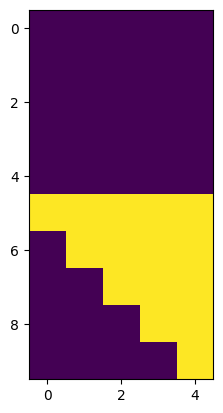

In [728]:
plt.imshow(ba[0,0,0])

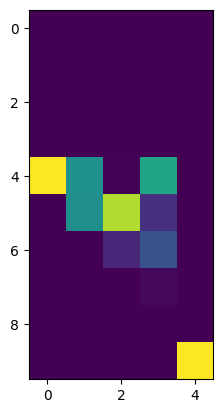

In [737]:
score_chank = tf.nn.softmax(ba, axis=3).numpy()
plt.imshow(score_chank[0,0,2])

5 15 5 10
10 20 10 15
15 25 15 20


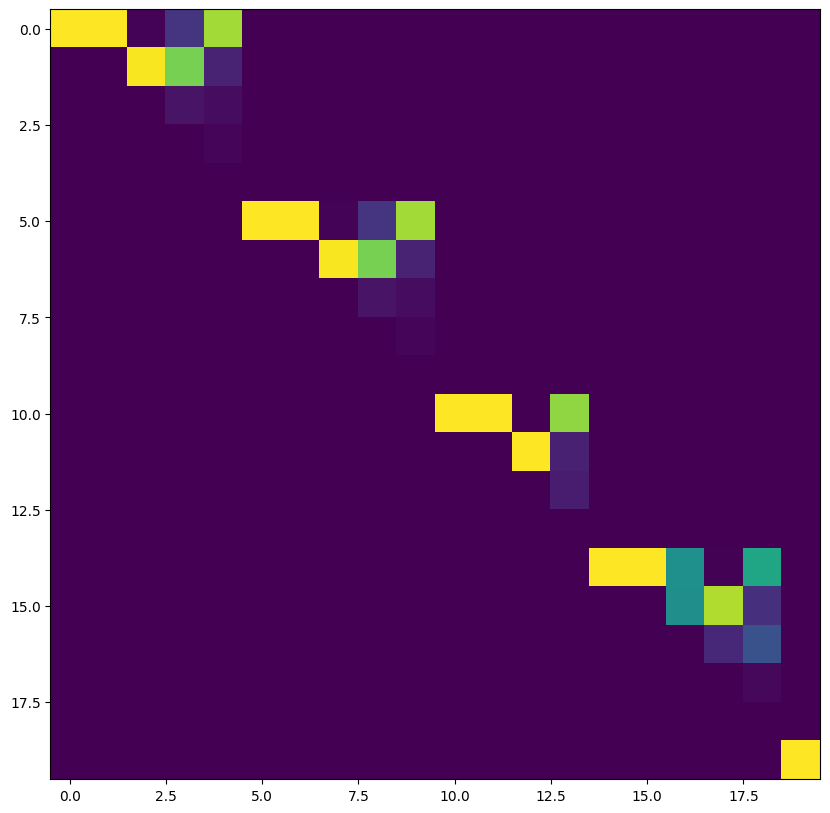

In [706]:
attn_score = np.zeros((batch_size,head_num, length, length))
attn_score[:,:,:m, :m] = score_chank[:,:,0,m:,:]
for i in range(0,n_buckets-1):
    attn_score[:,:,m*(i):m*(i+2), (i+1)*m:(i+2)*m] = score_chank[:,:,i,:,:]
plt.figure(figsize=(10,10))
plt.imshow(attn_score[0,0])

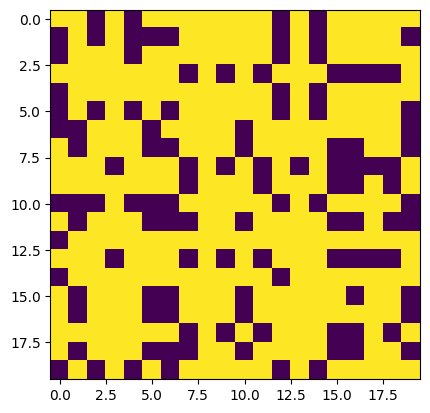

In [705]:
plt.imshow(attn_score[0,0])

[[[19 12 18  2 17 11 14  7  4  0 13  9 15  3 16  6  5  1  8 10]]]


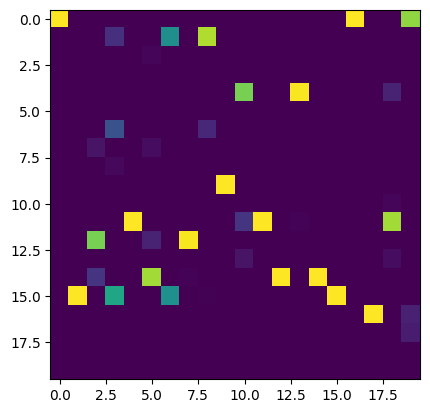

In [708]:
print(hash_sort_inv)
attn_score = np.take_along_axis(attn_score, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
attn_score = np.take_along_axis(attn_score, hash_sort_inv.reshape(batch_size,head_num,1,length), axis=3)
plt.imshow(attn_score[0,0])

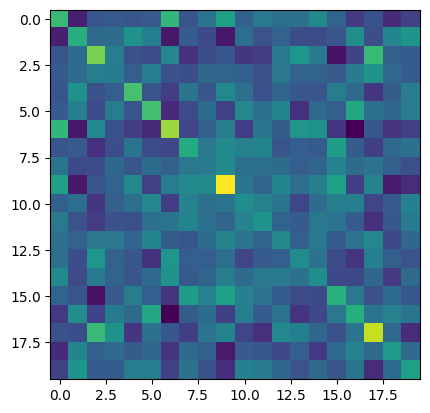

In [717]:
plt.imshow((QK@QK.transpose(0,1,3,2))[0,0])

array([[[[1.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.07649038, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.03131031, 0.        ,
          0.     

In [ ]:

# query×key
# 同一バケットで計算
# [batch_size, head_num, n_buckets, q_length//n_buckets, hidden_dim//head_num]@[batch_size, head_num, n_buckets, hidden_dim//head_num, q_length//n_buckets]
#       = [batch_size, head_num, n_buckets, q_length//n_buckets, q_length//n_buckets]
#a = QK_chank@QK_chank.transpose(0,1,2,4,3) - mask1
# ひとつ前のバケットと計算
# [batch_size, head_num, n_buckets-1, q_length//n_buckets, hidden_dim//head_num]@[batch_size, head_num, n_buckets-1, hidden_dim//head_num, q_length//n_buckets]
#       = [batch_size, head_num, n_buckets-1, q_length//n_buckets, q_length//n_buckets] 
#b = QK_chank[:,:,1:,:,:]@QK_chank[:,:,:-1,:,:].transpose(0,1,2,4,3) - mask2
# 大きさをそろえるためにpadding [batch_size, head_num, n_buckets, q_length//n_buckets, q_length//n_buckets] 
#b = np.pad(b,  [(0,0),(0,0),(1,0),(0,0),(0,0)], constant_values=-1e9)

# 各バケットでのattention score [batch_size, head_num, n_buckets, 2*q_length//n_buckets, q_length//n_buckets] →　[batch_size, head_num, n_buckets, q_length//n_buckets, 2*q_length//n_buckets]
#score_chank = tf.nn.softmax(np.concatenate([b,a], axis=4).transpose(0,1,2,3,4), axis=2).numpy()
#ba=tf.constant(np.concatenate([b,a], axis=3))


score_chank = tf.nn.softmax(ba, axis=3).numpy()#.transpose(0,1,2,4,3)

# valueをかけてattentionの出力を計算
# [batch_size, head_num, n_buckets, q_length//n_buckets, 2*q_length//n_buckets]@[batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
#       = [batch_size, head_num, n_buckets, 2*q_length//n_buckets, hidden_dim//head_num]
attn_weight_chank = score_chank.transpose(0,1,2,4,3)@V_chank

# attention scoreをもとの並び順に戻す
# [batch_size, head_num, q_length, q_length]
attn_score = np.zeros((batch_size,head_num, length, length))
attn_score[:,:,:n_buckets, :n_buckets] = score_chank[:,:,0,n_buckets:,:]
for i in range(0,n_buckets-1):
    attn_score[:,:,m*(i):m*(i)+m*2, (i+1)*m:(i+1)*m+m] = score_chank[:,:,i,:,:]
#attn_score = np.sort(np.concatenate([np.array(hash_sort).reshape(batch_size,head_num,length,1), attn_score.reshape(batch_size,head_num,length,length)], axis=3), axis=3)[:,:,:,1:]
#attn_score = attn_score[0,0,hash_sort_inv,]
#attn_score = attn_score[0,0,:,hash_sort_inv]
attn_score = np.take_along_axis(attn_score, hash_sort_inv.reshape(batch_size,head_num,length,1), axis=2)
attn_score = np.take_along_axis(attn_score, hash_sort_inv.reshape(batch_size,head_num,1,length), axis=3)


# attentionの出力をもとの並び順に戻す
#attn_weight_chank = np.sort(np.concatenate([np.array(hash_sort).reshape(batch_size,head_num,length,1), attn_weight_chank.reshape(batch_size,head_num,length,dk)], axis=3), axis=2)[:,:,:,1:]
attn_weight_chank = attn_weight_chank.reshape(batch_size,head_num,length,dk)[0,0,hash_sort_inv]